In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn import datasets, cluster

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: jonathanweske (use `wandb login --relogin` to force relogin)


True

In [3]:
# read CSV
df = pd.read_csv('../data/df_points/final_df_points_18_21.csv')

In [4]:
df = df.sort_values(by='dt_start', ignore_index=True)
df.head()

,bike_id,lat,lng,dt_start,dt_end,hex_id,hex_enc,temp,rain,snow,month,day,start_min,over_night,idle_time_next_day,idle_time
0,3694,51.323619,12.335887,1514764029,1514764799,881f1a8d91fffff,195,10.80,0.0,0.0,12,6,1427,1,821,12
1,2508,51.323619,12.335887,1514764035,1514764799,881f1a8d91fffff,195,10.80,0.0,0.0,12,6,1427,1,1439,12
2,41851,51.332415,12.395158,1514764638,1514764799,881f1a1659fffff,81,10.80,0.0,0.0,12,6,1437,1,1439,2
3,41851,51.332415,12.395158,1514764800,1514851199,881f1a1659fffff,81,10.86,0.0,0.0,1,0,0,1,82,1439
4,3694,51.323619,12.335887,1514764800,1514814103,881f1a8d91fffff,195,10.86,0.0,0.0,1,0,0,0,0,821


0.25      56.0
0.50     195.0
0.75     488.0
1.00    1439.0
Name: idle_time, dtype: float64

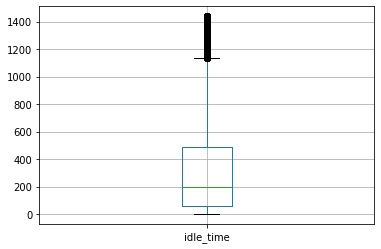

In [5]:
boxplot = df.boxplot(column=['idle_time'])
df['idle_time'].quantile([.25, .5,.75,1])

In [6]:
#add classification target
def f(row):
    if row['idle_time'] < 56:
        val = 1
    elif row['idle_time'] < 195:
        val = 2
    elif row['idle_time'] < 488:
        val = 3
    else:
        val = 4
    return val

df['idle_time_class'] = df.apply(f, axis=1)

In [7]:
df.tail()

,bike_id,lat,lng,dt_start,dt_end,hex_id,hex_enc,temp,rain,snow,month,day,start_min,over_night,idle_time_next_day,idle_time,idle_time_class
2547153,72243,51.367222,12.369617,1640897552,1640903562,881f1a8c8bfffff,170,13.19,7.62,0.0,12,3,1253,0,0,100,2
2547154,72058,51.317569,12.382730,1640897593,1640904368,881f1a1609fffff,47,13.19,7.62,0.0,12,3,1253,0,0,112,2
2547155,71949,51.334711,12.356763,1640897835,1640899343,881f1a1649fffff,75,13.19,7.62,0.0,12,3,1257,0,0,25,1
2547156,97785,51.367276,12.369792,1640898086,1640900985,881f1a8c8bfffff,170,13.05,2.03,0.0,12,3,1261,0,0,48,1
2547157,41738,51.366942,12.370322,1640900918,1640903516,881f1a8c8bfffff,170,13.05,2.03,0.0,12,3,1309,0,0,43,1


In [8]:
Label=['idle_time_class']
Target=['idle_time']
Predictors=['bike_id', 'lat', 'lng', 'temp', 'rain', 'snow', 'dt_start','hex_enc','start_min', 'month', 'day']

In [29]:
cX=df[Predictors].values
cy=df[Label].values

### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
cPredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=cPredictorScaler.fit(cX)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(cX)

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_size=0.2, random_state=42)

# Quick sanity check with the shapes of Training and testing datasets
print(cX_train.shape)
print(cy_train.shape)
print(cX_test.shape)
print(cy_test.shape)

(2037726, 11)
(2037726, 1)
(509432, 11)
(509432, 1)


# Classification
## RandomForestClassifier

In [10]:
from sklearn.neural_network import MLPClassifier

# Train model, get predictions
model_rfc = RandomForestClassifier(n_estimators=100)
model_rfc.fit(cX_train,cy_train.ravel())

cy_pred = model_rfc.predict(cX_test)
cy_probas = model_rfc.predict_proba(cX_test)
importances = model_rfc.feature_importances_
indices = np.argsort(importances)[::-1]

In [11]:
run = wandb.init(project='nb_idle_time_prediction', name="classification")

In [ ]:
wandb.sklearn.plot_learning_curve(model_rfc, cX_train, cy_train.ravel())

In [24]:
wandb.sklearn.plot_roc(cy_test, cy_probas)

In [23]:
wandb.sklearn.plot_confusion_matrix(cy_test.ravel(), cy_pred.ravel())

In [42]:
wandb.finish()

## MLPClassifier
# Fehler irgendwie

In [35]:
from sklearn.neural_network import MLPClassifier

model_cls = MLPClassifier(hidden_layer_sizes=(100,50,100), activation='relu', solver='adam', max_iter=1000, verbose=1, early_stopping=True)
model_cls.fit(cX_train,cy_train.ravel())

cy_exp_cls = cy_test
cy_pred_cls = model_cls.predict(cX_test)

print(model_cls.score(cX_test, cy_test))

Iteration 1, loss = 7.22192878
Validation score: 0.249837
Iteration 2, loss = 1.39195254
Validation score: 0.250504
Iteration 3, loss = 1.38639482
Validation score: 0.250504
Iteration 4, loss = 1.38640483
Validation score: 0.249783
Iteration 5, loss = 1.38642149
Validation score: 0.249876
Iteration 6, loss = 1.42419534
Validation score: 0.249876
Iteration 7, loss = 1.40822201
Validation score: 0.249876
Iteration 8, loss = 1.38635657
Validation score: 0.249876
Iteration 9, loss = 1.39104557
Validation score: 0.250504
Iteration 10, loss = 1.40233439
Validation score: 0.250504
Iteration 11, loss = 1.38634065
Validation score: 0.249876
Iteration 12, loss = 1.40092808
Validation score: 0.250504
Iteration 13, loss = 1.38632227
Validation score: 0.249876
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
0.2508774478242435


In [27]:
run = wandb.init(project='nb_idle_time_prediction', name="MLPClassifier")

In [31]:
cy_probas_cls = model_cls.predict_proba(cX_test)
wandb.sklearn.plot_roc(cy_exp_cls, cy_probas_cls)

In [32]:
wandb.sklearn.plot_confusion_matrix(cy_test.ravel(), cy_pred_cls.ravel())

In [37]:
cy_exp_cls

array([[1],
       [4],
       [4],
       ...,
       [3],
       [3],
       [2]])

In [36]:
cy_pred_cls

array([4, 4, 4, ..., 4, 4, 4])

In [41]:
wandb.finish()